<a href="https://colab.research.google.com/github/IsaiahAim/EuropeanTechOrganizationCluster/blob/main/business_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML
from sklearn.preprocessing import scale,RobustScaler,StandardScaler, MinMaxScaler




In [ ]:
# load data
data=pd.read_csv('tech_organization.csv',encoding= 'unicode_escape')

In [ ]:
data.head(2)

,name,ID,description,comment,url,city,city id,country,country id,linkedin,...,logo,acquired?,acquisition price,breakout,image (only for Breakout),COVID {up | down | stable},investor 1 (required),investor 2,CB score,ST score
0,Riskified,NaN,Riskified designs an e-commerce fraud-preventi...,NaN,riskified.com/,Tel Aviv,1,Israel,10,https://www.linkedin.com/company/riskified/,...,riskified,NaN,NaN,NaN,NaN,up,General Atlantic,Phoenix Insurance Company,1661,NaN
1,Fabric,NaN,Fabric is a company that builds a supply-chain...,NaN,getfabric.com/,Tel Aviv,1,Israel,10,http://linkedin.com/company/fabriclogistics/,...,getfabric,NaN,NaN,NaN,NaN,down,Playground Global,Temasek Holdings,261,NaN


In [ ]:
#missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
ST score,9279,1.000000
ID,9279,1.000000
comment,9278,0.999892
acquisition price,9277,0.999784
image (only for Breakout),9258,0.997737
breakout,9258,0.997737
COVID {up | down | stable},9185,0.989870
tag 3,8801,0.948486
acquired?,7883,0.849553
investor 2,5539,0.596939


In [ ]:
data['country'].nunique()

42

### Feature Engineering on Numerical data


In [ ]:
num_features=['CB score','total money raised (in USD)','last funding amount (in USD)']
numerical_df=data[num_features].copy()

def remove_currency(dataframe,column=[]):
    """ Remove currency symbol and delimiters,date strings 
         from  dataframe with 
        """
    try:
        for cols in column:
            dataframe[cols]=dataframe[cols].str.replace('$','')
            dataframe[cols]=dataframe[cols].str.replace(r'(\d{4}-\d{2}-\d{2})','')
            dataframe[cols]=dataframe[cols].str.replace(',','')
            dataframe[cols]=dataframe[cols].replace('',np.nan)
            dataframe[cols]=dataframe[cols].astype(float)
            
    except AttributeError as e:
            print(e)

#call function to remove, currency, and date strings from numerical features
remove_currency(numerical_df,num_features)

# Simple imputation of mean of numerical columns for missing data
for col in num_features:
    numerical_df.fillna(numerical_df[col].mean(),inplace=True)

# Standardization
numerical_df=pd.DataFrame(StandardScaler().fit_transform(numerical_df[num_features]),index=numerical_df.index,columns=num_features)
numerical_df=pd.DataFrame(MinMaxScaler(feature_range=(0,1)).fit_transform(numerical_df[num_features]),index=numerical_df.index,columns=num_features)

### Feature Engineering on Categorical data


In [ ]:
#Check for missing data
cat_features = ['city', 'country'  ,'investor 1 (required)','investor 2' ,'last funding type' ,'tag 1 (required)','company size','acquired?']
cat_df= data[cat_features].copy()

#Fill all missing values of the acquired column with not_acquired. 
cat_df['acquired_Imputed']=cat_df['acquired?'].fillna('not_acquired')

#Format replace datetime in company size to nan

cat_df['company size']=cat_df['company size'].str.replace(r'(\d{4}-\d{2}-\d{2})','')
cat_df['company size']=cat_df['company size'].replace('',np.nan)

#Function to replace NAN values with mode value
def impute_nan_most_frequent_category(DataFrame,ColName):
    # .mode()[0] - gives first category name
    most_frequent_category=DataFrame[ColName].mode()[0]
    
    # replace nan values with most occured category
    DataFrame[ColName + "_Imputed"] = DataFrame[ColName]
    DataFrame[ColName + "_Imputed"].fillna(most_frequent_category,inplace=True)
    
# Call function to impute most occured category
for Columns in cat_features:
    impute_nan_most_frequent_category(cat_df,Columns)


#new name of features after imputation
cat_features_imputed=[cols+"_Imputed" for cols in cat_features]

# Display imputed result
cat_df[cat_features_imputed]

#3. Drop actual columns
cat_df = cat_df.drop(cat_features, axis = 1)

#Transform Company SIZE to ordinal features, since the struture is hiereichical
def format_company_size(dataframe, column):
    for index in dataframe.index:
        if dataframe.loc[index,column]=='10001':
             dataframe.loc[index,column] = '1001-5000'
        elif dataframe.loc[index,column]=='70':
             dataframe.loc[index,column] = '51-100'
        elif dataframe.loc[index,column]=='43840':
             dataframe.loc[index,column]='10000 and above'
    
    dataframe[column] = dataframe[column].map({'1-10':0,'11-50':1,'51-100':2,'101-250':3,
                                               '251-500':4,'501-1000':5,'1001-5000':6,
                                               '5001-10000':7,'10000 and above':8})
format_company(cat_df,'company size_Imputed')


#useful_cols[useful_cols['company size']==1]
mx = MinMaxScaler(feature_range=(0,1))
ordinal_features = pd.DataFrame(mx.fit_transform(cat_df[['company size_Imputed']]),index=cat_df.index,columns=['company size_Imputed'])


#Tranform categorical data to nominal features
cat_features_imputed.remove('company size_Imputed')
nominal_features = pd.get_dummies(cat_df[cat_features_imputed])






## model

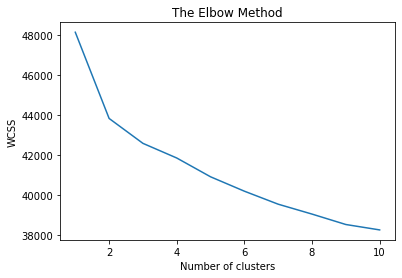

In [ ]:
scaled_data = pd.concat([numerical_features,nominal_features,ordinal_features],axis=1)
wcss = []  #within-cluster sum-of-squares
for i in range(1,11):
    kmeans = KMeans(n_clusters=i, init= 'k-means++', max_iter= 100, n_init=5, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
plt.plot(range(1,11),wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
from sklearn.cluster import KMeans
# fit cluster model and assign points to clusters
n_clusters=8
kmeans = KMeans(n_clusters)
kmeans.fit(scaled_data)
clusters = kmeans.predict(scaled_data)


### Generating Output


In [ ]:
#Create dataframe for grouping the clusters 
cluster_map = pd.DataFrame()
cluster_map['data_index'] = data.index.values
cluster_map['Group'] = kmeans.labels_

#Merge clusters with details from actual data

final_output=pd.merge(left=cluster_map, left_index=True,
                  right=data, right_index=True,
                  how='inner')


final_output.to_csv('international_company_groups.csv')